# Exploring Observation Data From Tilde, Application to DART Data

## &nbsp;Table of contents
### 1. Introduction
### 2. Building a Query for a specific sensor code/stream
### 3. Building a Query without sensor code/stream
### 4. Building a Query for the latest data
### 5. Building a Query for aggregated data
### 6. Getting the data using ObsPy

## &nbsp;1. Introduction

In this tutorial we will be learning how to use Python to access the Tilde API `data` endpoint. To highlight the different functionalities and the statistics available we will be using the DART (Deep-ocean Assessment and Reporting of Tsunami) dataset. Tilde is the GeoNet API (Application Programming Interface) to access DART time series data. You do not need to know anything about APIs to use this tutorial. If you would like more info see https://tilde.geonet.org.nz/v3/api-docs/. We developed this tutorial before detided data were available, and haven't added any specific sections since it became available, but the user can replace `water-height` with `water-height-detided` in any part of code to get the corresponding detided data.

This tutorial assumes you have basic knowledge of Python.

###### About GeoNet DART data

GeoNet uses the 12 DART Tsunameters deployed offshore New Zealand and around the Southwestern Pacific Ocean to monitor ocean height. When a change has been detected of a certain magnitude, the buoy will "trigger" and go into a heightened detection mode. The DARTs have two operational reporting modes; standard and event. When in standard reporting mode, the BPR (bottom pressure recorder) and buoy system send four six-hour bundles of 15 minute water height values. When in event reporting mode, BPR data are sampled at 15 second intervals and are sent more regularly. The buoy surface location (latitude and longitude) will also be sent daily. <br>
Tilde provides access to the 15 minute and 15 second sampled data, as well as the raw data.

For more DART information see the GeoNet page: https://www.geonet.org.nz/tsunami/dart

## &nbsp;2. Building a Query for a specific sensor code/stream

###### Import required modules and set the source URL

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO
from obspy import read

In [2]:
source = 'https://tilde.geonet.org.nz/v3'

### Request data for a specific sensor/stream with date range, and then returning a CSV file

This query returns the observations of the specified data held in Tilde. <br>
The endpoint we are going to use is `https://tilde.geonet.org.nz/v3/data/`.

The minimum required parameters are:
- domain = `dart`
- key = `NZJ/water-height/40/15m/-`, this is 15 minute sampled data for the station NZJ where the aspect is nil '-'
- startdate = '2022-03-31'
- enddate = '2022-03-31'

We will ask for data for 2022 March 31.

We begin by setting the URL with these new parameters.

In [3]:
url = source+'/data/dart/NZJ/water-height/40/15m/-/2022-03-31/2022-03-31'

We will now query the URL and ask for a CSV format to be returned

In [4]:
r = requests.get(url, headers={'Accept':'text/csv'})
print (r)

<Response [200]>


We use `requests.get` to retrieve the data from the URL. The response status code says whether we were successful in getting the data requested and why not if we were unsuccessful:
<ul>
<li>200 -- everything went okay, and the result has been returned (if any)
<li>301 -- the server is redirecting you to a different endpoint. This can happen when a company switches domain names, or an endpoint name is changed.
<li>400 -- the server thinks you made a bad request. This can happen when you don't send along the right data, among other things.
<li>404 -- the resource you tried to access wasn't found on the server.
</ul>

To work with the observation data we will use python's pandas module (https://pandas.pydata.org/). We will now store the response of our request in a pandas dataframe (`df`), using `pd.read_csv`. By using `parse_dates=['timestamp']` we can convert the 'time' to a datetime and with `index_col` we can set the time as the index of the  dataframe. More information on `pd.read_csv` can be found here: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html. We need to use the `StringIO` function with the text returned from our query. By printing the beginning of the result (`df.head()`) we can also see the result of this new index column.

In [5]:
df = pd.read_csv(StringIO(r.text),parse_dates=['timestamp'], index_col='timestamp')
df.head()

,domain,station,name,sensorCode,method,aspect,value,error,qualityControl
timestamp,,,,,,,,,
2022-03-31 00:00:00+00:00,dart,NZJ,water-height,40,15m,nil,1911.740,0.0,NaN
2022-03-31 00:15:00+00:00,dart,NZJ,water-height,40,15m,nil,1911.657,0.0,NaN
2022-03-31 00:30:00+00:00,dart,NZJ,water-height,40,15m,nil,1911.580,0.0,NaN
2022-03-31 00:45:00+00:00,dart,NZJ,water-height,40,15m,nil,1911.497,0.0,NaN
2022-03-31 01:00:00+00:00,dart,NZJ,water-height,40,15m,nil,1911.428,0.0,NaN


#### Data Summary
By using `df.describe` we can summarise the returned data as this features generates descriptive statistics from dataframes. From the result we can see that there are 96 values (and errors), and all of the qc values are currently undefined. By default, we also to get to see the mean, standard deviation, minimum, maximum, and some percentile values.

In [6]:
df.describe()

,sensorCode,value,error,qualityControl
count,96.0,96.000000,96.0,0.0
mean,40.0,1911.686635,0.0,NaN
std,0.0,0.447328,0.0,NaN
min,40.0,1911.044000,0.0,NaN
25%,40.0,1911.242750,0.0,NaN
50%,40.0,1911.672500,0.0,NaN
75%,40.0,1912.117250,0.0,NaN
max,40.0,1912.371000,0.0,NaN


##### Basic Data Plot
By using the `value` column from our dataframe we are able to plot the data against time. With Tilde if there is 15s data, the 15m values will be generated from this, so that there aren't any gaps in the 15m record, even though the DART was producing high rate data. To see the data periods that also include the 15s, we need to generate a plot that shows both.

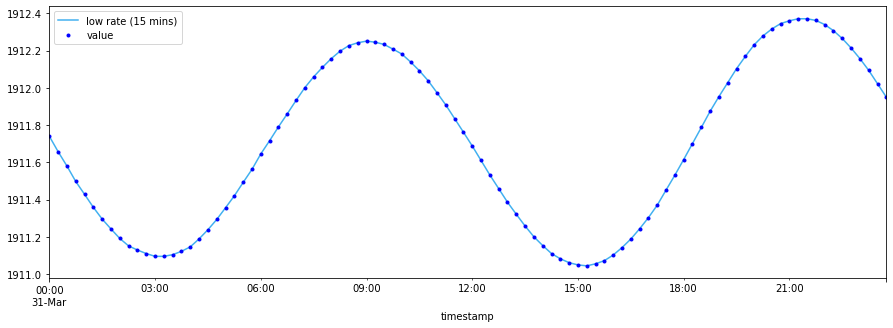

In [7]:
fig,ax = plt.subplots(figsize=(15,5))
df['value'].plot(ax=ax, color='#41b0f0', label='low rate (15 mins)')
df['value'].plot(ax=ax, color='blue', marker='.', linestyle='None')
    
#stop exponential format for y-axis label
ax.ticklabel_format(axis='y', useOffset=False, style='plain')

plt.legend(loc='best')

## &nbsp;3. Building a Query without sensor code/stream

Tilde can also provide all of the available data for a date range without having to specify the sensor code and stream parameters.

The minimum required parameters are:
- domain = `dart`
- key = `NZJ/water-height/-/-`
- startdate = '2022-01-23'
- enddate = '2022-01-23'

Using the above parameters will return data from all sensor codes for NZJ and all data types (15m and 15s). These will be returned in CSV format. 
The available location codes for each station are available in GeoNet's github repository (https://github.com/GeoNet/delta/blob/main/network/sites.csv). Sensor codes will be provided in the `Location` column (and for DART those will be either 40 or 41). <br>

We will begin by following similar steps to Section 2 and changing the URL with the new parameters, quering the URL and asking for the CSV format to be returned.

In [8]:
url = source+'/data/dart/NZJ/water-height/-/-/-/2022-01-23/2022-01-23'

r = requests.get(url, headers={'Accept':'text/csv'})

df = pd.read_csv(StringIO(r.text),parse_dates=['timestamp'], index_col='timestamp')

#####  Sorted by method not date
By printing the top 2 rows of the dataframe (`df.head(2)`) and the bottom 2 rows (`df.tail(2)`), we can see that the data returned is sorted by method (15m/15s) and not by date. 

In [9]:
df.head(2)

,domain,station,name,sensorCode,method,aspect,value,error,qualityControl
timestamp,,,,,,,,,
2022-01-23 00:00:00+00:00,dart,NZJ,water-height,40,15m,nil,1912.31,0.0,NaN
2022-01-23 00:15:00+00:00,dart,NZJ,water-height,40,15m,nil,1912.33,0.0,NaN


In [10]:
df.tail(2)

,domain,station,name,sensorCode,method,aspect,value,error,qualityControl
timestamp,,,,,,,,,
2022-01-23 19:59:30+00:00,dart,NZJ,water-height,40,15s,nil,1911.231,0.0,NaN
2022-01-23 19:59:45+00:00,dart,NZJ,water-height,40,15s,nil,1911.231,0.0,NaN


#### Separate 15s and 15m data into different dataframes
<br>
By separating into two distinct dataframes using the `method` column we can then separate out the 15m and the 15s values.

In [11]:
dfm = df[df['method']=='15m']
dfs = df[df['method']=='15s']

#### Basic visualization
<br>
As the two datatypes (15m and 15s) have now been separated, we can plot them with different colours. This is similar to the plot above, but now it is possible to see the low rate and the high rate data and how they fit together.

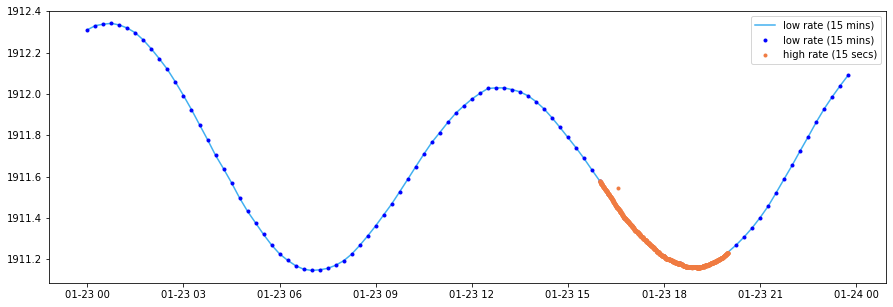

In [12]:
fig,ax = plt.subplots(figsize=(15,5))
ax.plot(dfm['value'], color='#41b0f0', label='low rate (15 mins)')
ax.plot(dfm['value'], color='blue', marker='.', linestyle='None', label='low rate (15 mins)')
ax.plot(dfs['value'], color='#f07b41', marker='.', linestyle='None', label='high rate (15 secs)')
    
#stop exponential format for y-axis label
ax.ticklabel_format(axis='y', useOffset=False, style='plain')

plt.legend(loc='best')

## &nbsp;4. Building a Query for the latest data

This query returns the observations of the specified data held in Tilde. The query is `https://tilde.geonet.org.nz/v3/data/`.

The minimum required parameters are:
- domain = `dart`
- key = `NZJ/water-height/40/15m/-`, this is 15 minute sampled data, with the aspect nil
- startdate = 'latest'
- enddate = '30d'

We will begin by following similar steps that we have followed previously by, changing the URL with the new parameters, quering the URL and asking for the CSV format to be returned. This request will return data in a CSV format for the last 30 days.

In [13]:
url = source+'/data/dart/NZJ/water-height/40/15m/-/latest/30d'

r = requests.get(url, headers={'Accept':'text/csv'})

df = pd.read_csv(StringIO(r.text),parse_dates=['timestamp'], index_col='timestamp')

We can see in the tail of the dataframe that we have the `latest` or most recent data.

In [14]:
df.tail()

,domain,station,name,sensorCode,method,aspect,value,error,qualityControl
timestamp,,,,,,,,,
2023-02-01 23:00:00+00:00,dart,NZJ,water-height,40,15m,nil,1911.650,0.0,NaN
2023-02-01 23:15:00+00:00,dart,NZJ,water-height,40,15m,nil,1911.605,0.0,NaN
2023-02-01 23:30:00+00:00,dart,NZJ,water-height,40,15m,nil,1911.564,0.0,NaN
2023-02-01 23:45:00+00:00,dart,NZJ,water-height,40,15m,nil,1911.524,0.0,NaN
2023-02-02 00:00:00+00:00,dart,NZJ,water-height,40,15m,nil,1911.485,0.0,NaN


#### Data volume
<br>
By using `len(df.index)` we can easily generate a row count of the dataframe. This could be useful to see how many values we received in a certain period of time for a station. As we are looking at the low rate data, this is likely to be quite predictable, as this is the data that we regularly receive, however, for the high rate (triggered) data we would likely expect much fewer values, unless there has been a lot of recent activity. In this case, for the last 30 days we have received nearly 3000 observations of low rate data.

In [15]:
len(df.index)

2873

#### Basic visualization of the data 
<br>
Plotting the low rate data over the 30 day period allows us to visualise the different tidal periods. 

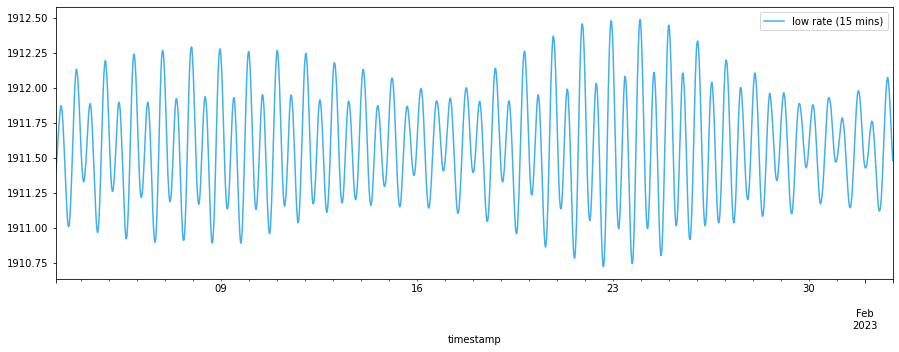

In [16]:
fig,ax = plt.subplots(figsize=(15,5))
df['value'].plot(ax=ax, color='#41b0f0', label='low rate (15 mins)')
    
#stop exponential format for y-axis label
ax.ticklabel_format(axis='y', useOffset=False, style='plain')

plt.legend(loc='best')

## &nbsp;5. Building a query for aggregated data
<br>
When requesting a large amount of data over a long time period, the query can be optimized for quick visualisation using the optional `aggregationPeriod`and `aggregationFunction` parameters. We will use the same example as above, but for a 8 month range (2021-08-01 to 2022-03-31) and use an aggregation period of 1 day to return a daily mean of the values. Notice that, due to the aggregation, our dataframe's index column has time values 00:00:00.

In [17]:
url = source+'/data/dart/NZJ/water-height/-/-/-/2021-08-01/2022-03-31?aggregationPeriod=1d&aggregationFunction=mean'

r = requests.get(url, headers={'Accept':'text/csv'})
df = pd.read_csv(StringIO(r.text),parse_dates=['timestamp'], index_col='timestamp')
df.tail(5)

,domain,station,name,sensorCode,method,aspect,value,error,qualityControl
timestamp,,,,,,,,,
2022-01-15 00:00:00+00:00,dart,NZJ,water-height,40,15s,nil,1911.735176,0.0,NaN
2022-01-16 00:00:00+00:00,dart,NZJ,water-height,40,15s,nil,1911.768006,0.0,NaN
2022-01-17 00:00:00+00:00,dart,NZJ,water-height,40,15s,nil,1911.806812,0.0,NaN
2022-01-22 00:00:00+00:00,dart,NZJ,water-height,40,15s,nil,1911.718939,0.0,NaN
2022-01-23 00:00:00+00:00,dart,NZJ,water-height,40,15s,nil,1911.277562,0.0,NaN


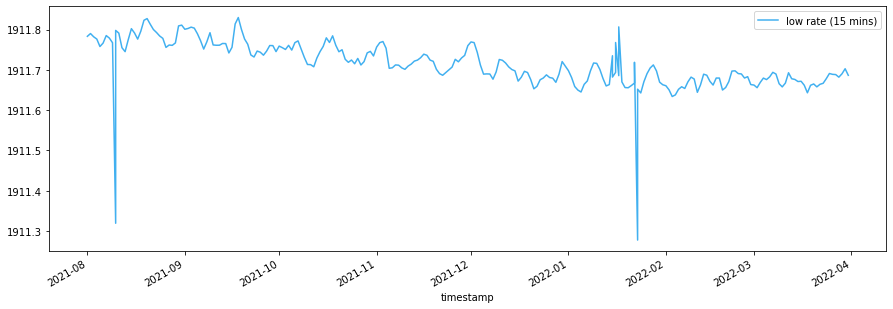

In [18]:
fig,ax = plt.subplots(figsize=(15,5))
df['value'].plot(ax=ax, color='#41b0f0', label='low rate (15 mins)')
  
ax.ticklabel_format(axis='y', useOffset=False, style='plain')

plt.legend(loc='best')

## &nbsp;6. Getting the data using ObsPy

ObsPy (https://github.com/obspy/obspy/wiki) is a python module used for analysis of seismological data.

By getting the data into ObsPy we can use all of the functionality that comes with it. To enable us to do this, we will use the TSPAIR format. More information on this can be found here: https://docs.obspy.org/packages/autogen/obspy.io.ascii.core._write_tspair.html

To begin, we will create a dataframe column that is formatted as needed. A change of formatting is required for the time series file as obspy modules can't read it as it is, so we will change the format to be like this: YYYY-MM-DDTHH:MM:SS ('%Y-%m-%dT%H:%M:%S'). 

In [19]:
url = source+'/data/dart/NZJ/water-height/40/15m/-/latest/30d'
r = requests.get(url, headers={'Accept':'text/csv'})
df = pd.read_csv(StringIO(r.text),parse_dates=['timestamp'], index_col='timestamp')

df['tseries'] = df.index.strftime('%Y-%m-%dT%H:%M:%S')
#print(df['tseries'])

Next we need to generate a header for the time-series file, where we specify a few parameters. This is required so that ObsPy can read the file, and has important data such as the sampling rate.

TSPAIR is a simple ASCII time series format. Each continuous time series segment (no gaps or overlaps) is represented with a header line followed by data samples in time-sample pairs. There are no restrictions on how the segments are organized into files, a file might contain a single segment or many, concatenated segments either for the same channel or many different channels.

Header lines have the general form: TIMESERIES SourceName, # samples, # sps, Time, Format, Type, Units.
The sourcename should be of the format `Net_Sta_Loc_Chan_Qual`, so for NZJ this is `NZ_NZJ_40_15m_R`. For the number of samples, we can use `len(df.index)` as we used above. For number of samples per second, as we are using low rate data (15m) this would be 15 minutes or 0.0011111 samples per second. For time, we are using the time dataframe column that we generated above. The format is TSPAIR, the datatype is a float and the units are in `mm`.

In [20]:
sourcename = 'NZ_NZJ_40_15m_R'
samples = len(df.index)
sps = 0.0011111111111111111
time = df['tseries'][0]
dformat = 'TSPAIR'
dtype = 'FLOAT'
units = 'mm'

headerstr = 'TIMESERIES '+sourcename+', '+str(samples)+' samples, '+str(sps)+' sps, '+time+', TSPAIR, FLOAT, mm\n'

First we open a new file called tspair.dat, then we write the appropriate header string and then using `df.to_csv` we can write the time-series data to the same file. Finally, we close the file.

In [21]:
f = open('tspair.dat', 'w')
f.write(headerstr)
df.to_csv(f, columns=['tseries', 'value'], sep=' ', index=False, header=False, mode='a')
f.close()

We can now read the file `tspair.dat`as an Obspy stream using `read()`, where the file format is TSPAIR as specified when we generated the header string.

In [22]:
st = read('tspair.dat', format='TSPAIR')

From this string we can then pull out the first trace (`tr`) of the stream and print it's statistics. These statistics are generated from the header string that we made beforehand and is why it is important that those details are correct.

In [23]:
tr=st[0]
tr.stats

         network: NZ
         station: NZJ
        location: 40
         channel: 15m
       starttime: 2023-01-03T02:00:00.000000Z
         endtime: 2023-02-02T00:00:00.000000Z
   sampling_rate: 0.0011111111111111111
           delta: 900.0
            npts: 2873
           calib: 1.0
         _format: TSPAIR
           ascii: AttribDict({'unit': 'mm'})
           mseed: AttribDict({'dataquality': 'R'})

As a final step, we can also plot this trace and see how it compares to the waveform that we generated at the end of Section 4.

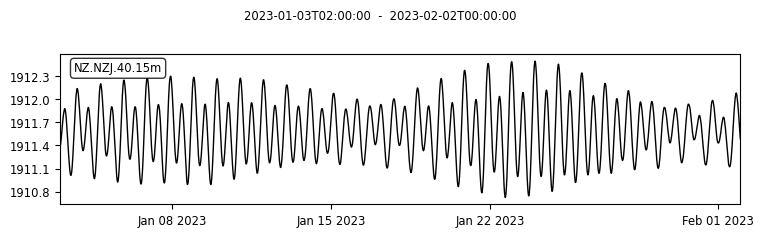

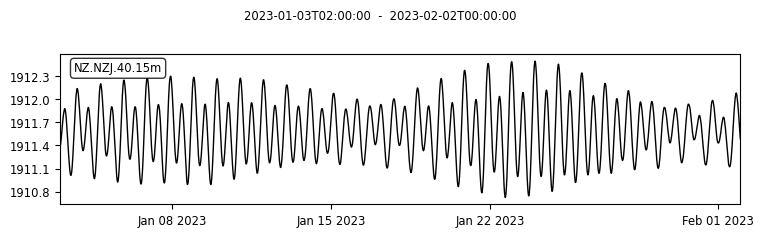

In [24]:
tr.plot()